# Single-Instance Simulations for Hard SK Instances

**This is a combination of both the analyse_fluctuations and adaptive_annealing notebook, adapted from Tim**

In [21]:
using DifferentialEquations, ForwardDiff, BoundaryValueDiffEq
using Combinatorics
using QAOA, Yao
using Interpolations, LinearAlgebra, Arpack, SparseArrays, NLopt
using PyPlot, HDF5, Printf

PyPlot.plt.style.use("~/paper.mplstyle") 
rc("text", usetex=true)

include("/home/ubuntu/.julia/dev/AdaptiveQuantumAnnealing/src/pick_flucs.jl")

perfect_metric (generic function with 1 method)

In [22]:
import Random

In [23]:
using Revise, Arrow, DataFrames
using AdaptiveQuantumAnnealing, SpinFluctuations

In [24]:
Base.show(io::IO, f::Float64) = @printf(io, "%1.4e", f)

In [25]:
N = 13;

## SK Instance

In [6]:
PATH = PATH = "/home/ubuntu/Archives/"
subdir = "small_gaps"
# subdir = "large_gaps"
folder_name = PATH * @sprintf("data/tb_mount/N_%i/%s/", N, subdir);

In [7]:
seed = 100130		
spin_idx = 2
filename = folder_name * @sprintf("random_SK_instance_N_%i_seed_%i.h5", N, seed)
J_mat = h5read(filename, "J");
mf_problem = Problem(0, J_mat);

In [8]:
# datafile = PATH * @sprintf("HDF5/results_max2sat_hard_instance_%03i_from_arxiv_1401_7320_N_%i_num_clauses_%i.h5", idx, N, num_clauses);

In [9]:
T_final = 32768.
npts = 2048
# npts = 4096
coarse_times = range(0, 1, npts + 1);
exact_times = range(0, 1, 33);

## Exact gap

In [10]:
λ = h5read(folder_name * @sprintf("random_SK_instance_N_%i_seed_%i.h5", N, seed), "exact_ARPACK_LM_eigvals");

In [11]:
gap = λ[2, :] .- λ[1, :];
mingap = minimum(gap)
mingap |> println
gap_idx = findfirst(x -> x == mingap, gap)
gaploc = exact_times[gap_idx]
gaploc |> println

2.9286e-03
9.0625e-01


In [12]:
# h5open(folder_name * @sprintf("results_random_SK_instance_N_%i_seed_%i.h5", N, seed))

In [13]:
T_final = 32000
tol = 1e-8
bogo_spec = h5read(folder_name * @sprintf("results_random_SK_instance_N_%i_seed_%i.h5", N, seed), 
                   @sprintf("bogoliubov_spectrum_T_final_%.0f_tol_1e%.0f_npts_%i", T_final, log10(tol), 32));

In [14]:
all_eigvecs = h5read(folder_name * @sprintf("random_SK_instance_N_%i_seed_%i.h5", N, seed), "exact_ARPACK_LM_lowest_eigvecs");

In [15]:
H_x = SpinFluctuations.hamiltonian(1, 0, mf_problem.local_fields, mf_problem.couplings)
H_z = SpinFluctuations.hamiltonian(0, 1, mf_problem.local_fields, mf_problem.couplings);

In [16]:
gs = [all_eigvecs[k, :, 1] for k in 1:length(exact_times)]
first_ex = [all_eigvecs[k, :, 2] for k in 1:length(exact_times)]
second_ex = [all_eigvecs[k, :, 3] for k in 1:length(exact_times)]

overlap_01_x = [first_ex[k]' * H_x * gs[k] for k in 1:length(exact_times)]
overlap_01_z = [first_ex[k]' * H_z * gs[k] for k in 1:length(exact_times)]

overlap_02_x = [second_ex[k]' * H_x * gs[k] for k in 1:length(exact_times)]
overlap_02_z = [second_ex[k]' * H_z * gs[k] for k in 1:length(exact_times)];

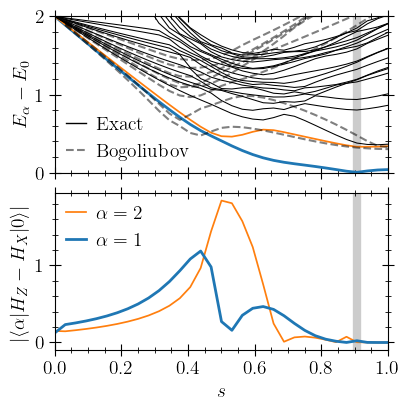

In [17]:
figure(figsize = (4, 4))

ax = subplot(211)
axvline(gaploc, ls = "-", c="k", alpha=0.2, lw=6)
for i in 1:20
	if i == 2 
		plot(exact_times, (λ[i, :] .- λ[1, :]), lw = 2.0, alpha = 1)
	elseif i == 3		
		plot(exact_times, (λ[i, :] .- λ[1, :]), lw = 1.25, alpha = 1)
	else
		plot(exact_times, (λ[i, :] .- λ[1, :]), "-k", lw=0.75, alpha = 1)
	end
	plot(exact_times[2:end], bogo_spec[i, :] , "--k", lw = 1.5, alpha=0.5)
end
plot([], [], "-k", lw = 1, label = "Exact")
plot([], [], label = "Bogoliubov", "--k", lw=1.5, alpha = 0.5)
xlim(0.0, 1.0)
ax.set_yticks(2 .* [0, 0.5, 1.0])
ylim(0, 2)
ax.set_xticklabels([])
ylabel("\$E_\\alpha - E_0\$")
legend(frameon = false, handlelength=1., handletextpad=0.5, borderaxespad=0.2)

ax = subplot(212)
axvline(gaploc, ls = "-", c="k", alpha=0.2, lw=6)
plot(exact_times, abs.(overlap_02_z .- overlap_02_x), label = "\$\\alpha = 2\$", "-C1", lw=1.25)
plot(exact_times, abs.(overlap_01_z .- overlap_01_x), label = "\$\\alpha = 1\$", "-C0", lw=2.0)
xlim(0.0, 1.0)
ax.set_yticks([0, 1.0])
# ylim(0, 1)
xlabel("\$s\$")
ylabel("\${|\\langle \\alpha|H_Z-H_X|0\\rangle|}\$")

legend(ncol=1, handlelength=1., handletextpad=0.5, borderaxespad=0.2, loc="upper left")

tight_layout(pad=0.25)
# savefig(PLOT_PATH * @sprintf("exact_spectrum_N_%i_seed_%i.pdf", N, seed), dpi=256, bbox_inches="tight")
display(gcf())

## Mean-field trajectories

In [18]:
T_final = 32768.
tol = 1e-6
sol_t = h5read(folder_name * @sprintf("results_random_SK_instance_N_%i_seed_%i.h5", N, seed), @sprintf("mean_field_T_final_%.0f_tol_1e%.0f/times", T_final, log10(tol)))
sol_u = h5read(folder_name * @sprintf("results_random_SK_instance_N_%i_seed_%i.h5", N, seed), @sprintf("mean_field_T_final_%.0f_tol_1e%.0f/trajectories", T_final, log10(tol)));

In [19]:
size(sol_u)

(104598, 3, 12)

### Bloch coordinates, Magnetization & Complex Coordinates

In [82]:
nx_vals = n_vals("x", sol_u)
ny_vals = n_vals("y", sol_u)
nz_vals = n_vals("z", sol_u);

In [83]:
nx_coarse = n_coarse(nx_vals, sol_t, coarse_times)
ny_coarse = n_coarse(ny_vals, sol_t, coarse_times)
nz_coarse = n_coarse(nz_vals, sol_t, coarse_times);

In [84]:
S_vals = [transpose(reduce(hcat, [nx_coarse[:, k], ny_coarse[:, k], nz_coarse[:, k]])) |> Matrix for k in 1:npts+1]
magnetizations = reduce(hcat, map(S -> magnetization(S, mf_problem.local_fields, mf_problem.couplings), S_vals));

In [85]:
areas = Dict()
EA_param = Dict()
# dts = [(x[2] - x[1]) / T_final for x in zip(sol_t[1:end-1], sol_t[2:end])]
dts = [(x[2] - x[1]) / T_final for x in zip(coarse_times[1:end-1], coarse_times[2:end])]
for spin_idx in 1:N-1
	# areas[spin_idx] = sum(dts .* nz_vals[spin_idx, 2:end]) |> abs
	areas[spin_idx] = sum(dts .* magnetizations[spin_idx, 2:end]) |> abs

	# Edwards-Anderson
	EA_param[spin_idx] = (1/(N-1)) * sum(dts .* nz_coarse[spin_idx, 2:end] .^ 2) |> abs
end

top_idxs = [k for (k, v) in sort(areas |> collect, by = x -> x[2])]
top_idxs = [k for (k, v) in sort(EA_param |> collect, by = x -> x[2])]
top_idx = top_idxs[1]

6

In [86]:
[(spin_nr, 1e4A) for (spin_nr, A) in sort(EA_param |> collect, by = x -> x[2])]

12-element Vector{Tuple{Int64, Float64}}:
 (6, 4.5150e-03)
 (1, 5.7901e-03)
 (2, 6.4485e-03)
 (9, 9.6314e-03)
 (8, 9.8127e-03)
 (4, 1.0086e-02)
 (11, 1.1422e-02)
 (5, 1.1949e-02)
 (3, 1.1977e-02)
 (10, 1.2069e-02)
 (12, 1.2406e-02)
 (7, 1.3311e-02)

In [87]:
[(spin_nr, 1e4A) for (spin_nr, A) in sort(areas |> collect, by = x -> x[2])]

12-element Vector{Tuple{Int64, Float64}}:
 (6, 3.3888e-02)
 (2, 4.3963e-02)
 (1, 6.8380e-02)
 (8, 9.9301e-02)
 (9, 1.2147e-01)
 (4, 1.6315e-01)
 (11, 2.2750e-01)
 (10, 2.3340e-01)
 (5, 2.4023e-01)
 (12, 2.8519e-01)
 (3, 2.9317e-01)
 (7, 3.9494e-01)

In [88]:
regular_trajectories = filter!(x -> x != top_idx, collect(1:N-1));
# regular_trajectories = filter!(x -> x != top_idxs[2], regular_trajectories);

11-element Vector{Int64}:
  1
  2
  3
  4
  5
  7
  8
  9
 10
 11
 12

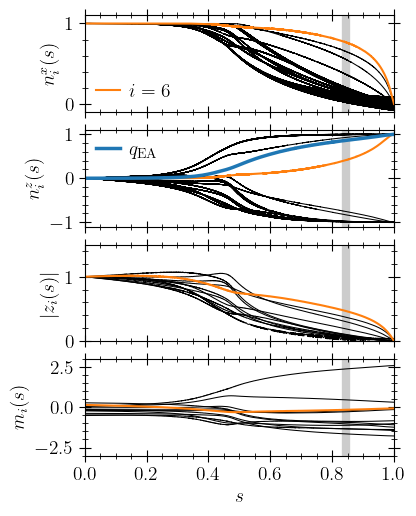

In [89]:
figure(figsize = (4, 5))

c1 = "-C1"
c2 = "-C0"

ax = subplot(411)
axvline(gaploc, ls = "-", c="k", alpha=0.2, lw=6)
for spin_nr in regular_trajectories
	plot(sol_t ./ sol_t[end], nx_vals[spin_nr, :], "-k", lw=0.75)
end
# plot(sol_t ./ sol_t[end], nx_vals[top_idxs[2], :], c2, lw=1, label = @sprintf("\$i=%i\$", top_idxs[2]))
plot(sol_t ./ sol_t[end], nx_vals[top_idx, :], c1, lw=1.5, label = @sprintf("\$i=%i\$", top_idx))
xlim(0, 1)
ax.set_xticklabels([])
ylim(-0.1, 1.1)
ylabel("\$n_i^x(s)\$")
legend(handlelength=1.2, handletextpad=0.5, borderaxespad=0.2)

ax = subplot(412)
axvline(gaploc, ls = "-", c="k", alpha=0.2, lw=6)
for spin_nr in regular_trajectories
	plot(sol_t ./ T_final, nz_vals[spin_nr, :], "-k", lw=0.75)
end
# plot(sol_t ./ T_final, nz_vals[top_idxs[2], :], c2, lw=1)
plot(sol_t ./ T_final, nz_vals[top_idx, :].^2, c1, lw=1.5)

# Edwards-Anderson
plot(coarse_times, sum([nz_coarse[spin_nr, :] .^ 2 for spin_nr in 1:N-1]) ./ (N-1), "-C0", lw=2.5, label="\$q_{\\mathrm{EA}}\$")
xlim(0, 1)
ylim(-1.1, 1.1)
ax.set_xticklabels([])
ylabel("\$n_i^z(s)\$")
legend(handlelength=1.2, handletextpad=0.5, borderaxespad=0.2)

ax = subplot(413)
axvline(gaploc, ls = "-", c="k", alpha=0.2, lw=6)
for spin_nr in regular_trajectories
	plot(coarse_times, (abs.(complex_coordinate(spin_nr, nx_coarse, ny_coarse, nz_coarse))), "-k", lw=0.75)
end
# plot(coarse_times, (abs.(complex_coordinate(top_idxs[2], nx_coarse, ny_coarse, nz_coarse))), c2, lw=1, label = @sprintf("\$i=%i\$", top_idxs[2]))
plot(coarse_times, (abs.(complex_coordinate(top_idx, nx_coarse, ny_coarse, nz_coarse))), c1, lw=1.5, label = @sprintf("\$i=%i\$", top_idx))

xlim(0, 1)
ylim(0, 1.5)
ax.set_xticklabels([])
ylabel("\$|z_i(s)|\$")

ax = subplot(414)
axvline(gaploc, ls = "-", c="k", alpha=0.2, lw=6)
for spin_nr in regular_trajectories
	plot(coarse_times, magnetizations[spin_nr, :], "-k", lw=0.75)
end
# plot(coarse_times, magnetizations[top_idxs[2], :], c2, lw=1, label = @sprintf("\$i=%i\$", top_idxs[2]))
plot(coarse_times, magnetizations[top_idx, :], c1, lw=1.5, label = @sprintf("\$i=%i\$", top_idx))

xlim(0.0, 1)
ylim(-3, 3)
xlabel("\$s\$")
ylabel("\$m_i(s)\$")

tight_layout(pad=0.1)
display(gcf())
# savefig(PLOT_PATH * @sprintf("mean_fields_N_%i_seed_%i.pdf", N, seed), dpi=256, bbox_inches="tight")
# PythonPlot.close();

## Energies

In [90]:
sigma_star = sign.(sol_u[end, 3, :])
h = mf_problem.local_fields
J = mf_problem.couplings
E = sum([-h[l] * sigma_star[l] for l in 1:N-1]) + sum([-J[i, j] * sigma_star[i] * sigma_star[j] for i in 1:N-1 for j in (i+1):N-1])

-6.8670e+00

In [91]:
[λ[k, :][end] for k in 1:6] |> println

[-7.2630e+00, -7.1272e+00, -7.1262e+00, -6.8670e+00, -6.8472e+00, -6.7373e+00]


In [92]:
isapprox.([λ[k, :][end] for k in 1:6], E, atol=1e-5) |> println

Bool[0, 0, 0, 1, 0, 0]


## Metric from Statistical Green Function

In [93]:
T_final = 32000.
tol = 1e-8
all_flucs = h5read(folder_name * @sprintf("results_random_SK_instance_N_%i_seed_%i.h5", N, seed), @sprintf("fluctuations_T_final_%.0f_tol_1e%.0f_npts_%i", T_final, log10(1e-8), npts));

In [94]:
navg = 128
sum_flucs_f_shifted = linear_interpolation(coarse_times[1:end - navg + 1], AdaptiveQuantumAnnealing.moving_average(sum([all_flucs[i, :] for i in 1:N-1]), navg), extrapolation_bc=Line())
sum_flucs_f = x -> sum_flucs_f_shifted(x - (navg - 1) / 2npts)
∂_sum_flucs_f = x -> ForwardDiff.derivative(sum_flucs_f, x);

In [95]:
local_EA_param = nz_coarse[top_idx, :].^2
scale_factor = 1 .+ abs.(complex_coordinate(top_idx, nx_coarse, ny_coarse, nz_coarse)) .^ 2;

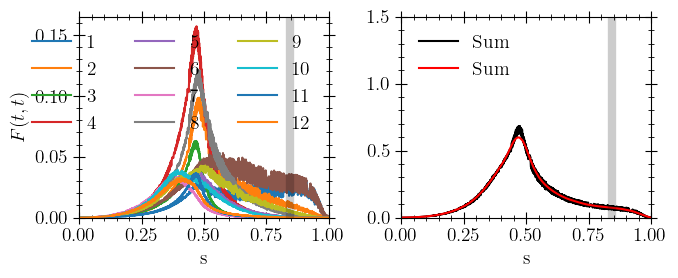

In [96]:
figure(figsize=(7, 3))

subplot(121)
for i in 1:N-1
    plot(coarse_times, all_flucs[i, :], label=string(i))
end
axvline(gaploc, ls = "-", c="k", alpha=0.2, lw=6)
xlim(0., 1.)
ylim(0., )
xlabel("s")
ylabel("\$F(t, t)\$")
legend(frameon=false, ncol=3)

subplot(122)
plot(coarse_times, sum([all_flucs[i, :] for i in 1:N-1]), "-k", label="Sum")
# plot(coarse_times[2:end], adiabatic_lyapunov_exponent, label="Max. LE")
plot(coarse_times, map(sum_flucs_f, coarse_times), "-r", label="Sum")
# plot(coarse_times, map(∂_sum_flucs_f, coarse_times), "-r")

# gap_marker = (x, gap_loc) -> exp(-(x - gap_loc)^2 / 3e-2)
# plot(coarse_times, map(x -> gap_marker(x, 0.35), coarse_times), "-r")
axvline(gaploc, ls = "-", c="k", alpha=0.2, lw=6)
xlim(0., 1.)
ylim(0., 1.5)
legend(frameon=false, ncol=1)
xlabel("s")
tight_layout()
display(gcf())

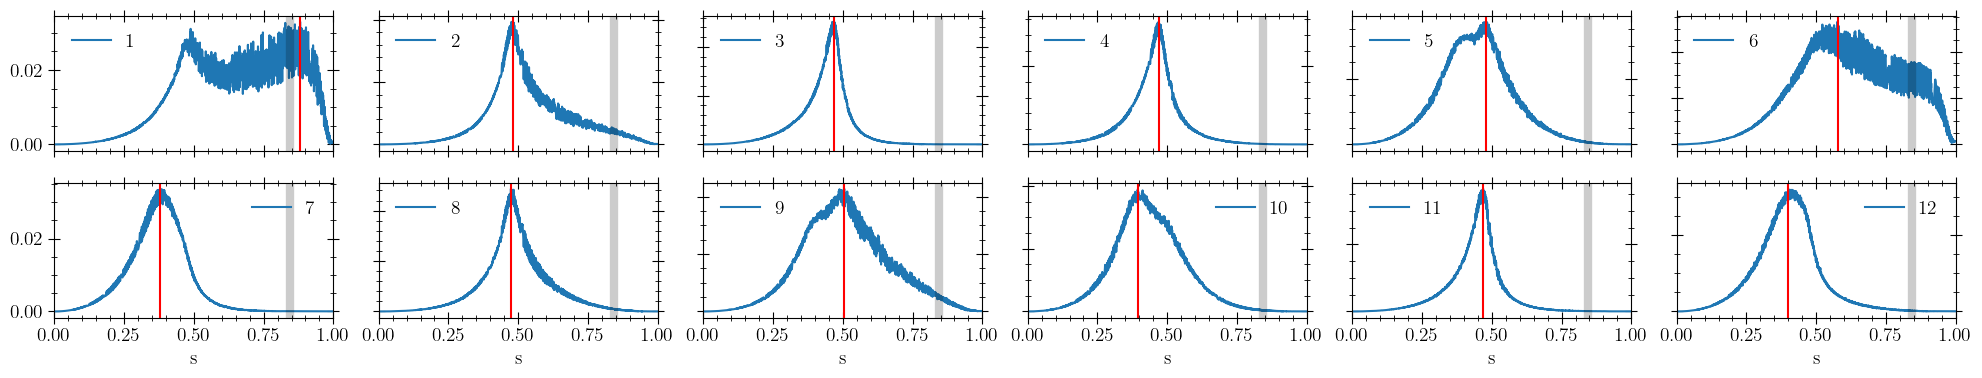

In [97]:
figure(figsize=(20, 4))
for i in 1:(N-1)÷2
    ax = subplot(2, (N-1)÷2, i)
    plot(coarse_times, all_flucs[i, :], label=string(i))
    axvline(coarse_times[findfirst(x -> x == maximum(all_flucs[i, :]), all_flucs[i, :])], c="r")
    axvline(gaploc, ls = "-", c="k", alpha=0.2, lw=6)
    xlim(0., 1.)
    ax.set_xticklabels([])
    # ylim(0., 1)
    if i > 1
        ax.set_yticklabels([])
    end
    legend(frameon=false, ncol=2)
end

for i in (N-1)÷2+1:(N-1)
    ax = subplot(2, (N-1)÷2, i)
    plot(coarse_times, all_flucs[i, :], label=string(i))
#     println(i, ": ", maximum(all_flucs[i, :]))
    axvline(coarse_times[findfirst(x -> x == maximum(all_flucs[i, :]), all_flucs[i, :])], c="r")    
    axvline(gaploc, ls = "-", c="k", alpha=0.2, lw=6)
    xlim(0., 1.)
    # ylim(0., 1)
    if i > (N-1)÷2+1
        ax.set_yticklabels([])
    end    
    xlabel("s")    
    legend(frameon=false, ncol=2)
end
tight_layout()
display(gcf())

In [108]:
g_ninterp = 20000
g_navg = 500
C = 5
δₓ = 0.0
metric_parameters = MetricParameters(g_ninterp, g_navg, C, δₓ);

In [109]:
# g = metric(metric_parameters, all_flucs[top_idx, 2:end] ./ maximum(all_flucs[top_idx, 2:end]), coarse_times)
g = metric(metric_parameters, smoothen(scale_factor[2:end].^2 .* all_flucs[top_idx, 2:end] .* local_EA_param[2:end], coarse_times[2:end], navg=256), coarse_times)
# g = metric(metric_parameters, map(x -> gap_marker(x, 0.35), coarse_times)[2:end], coarse_times)

#8 (generic function with 1 method)

In [110]:
g_norm(x) = C .* g(x)./(1 * maximum(g.(range(0,1,1000))) )

g_norm (generic function with 1 method)

In [111]:
∂g = x -> ForwardDiff.derivative(g, x)

# Christoffel symbols
Γ_AD = x -> g(x) * ∂g(x) / 2.0

navg = 2000
ninterp = 50000
x = range(0., 1.0, ninterp + 1)

Γ_shifted = linear_interpolation(x[1:end - navg + 1], AdaptiveQuantumAnnealing.moving_average(map(Γ_AD, x), navg), extrapolation_bc=Line())
Γ = x -> Γ_shifted(x - (navg - 1) / 2ninterp)

#115 (generic function with 1 method)

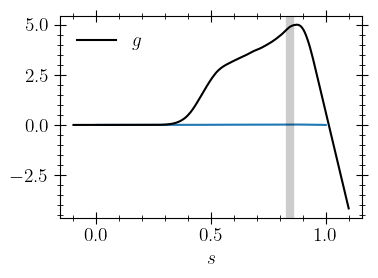

In [112]:
figure(figsize=(4, 3))

subplot(111)
# plot(coarse_times[1:end], smoothen(all_flucs[top_idx, 1:end], coarse_times, navg=64))
bare_metric = smoothen(scale_factor.^2 .* all_flucs[top_idx, 1:end] .* local_EA_param, coarse_times, navg=128)
plot(coarse_times[1:end], bare_metric)
# plot(range(-0.1, 1.1, 201), map(g, range(-0.1, 1.1, 201)) ./ C, "-k", ms=2, label="\$g\$")
plot(range(-0.1, 1.1, 201), map(g_norm, range(-0.1, 1.1, 201)), "-k", ms=2, label="\$g\$")
axvline(gaploc, ls = "-", c="k", alpha=0.2, lw=6)
# xlim(-0., 1.)
# ylim(0, 5)
xlabel("\$s\$")
legend(frameon=false)

tight_layout()
display(gcf())

In [113]:
# sigmoid_filter = x -> 1/(1 + exp(-1000(x - 0.25maximum(bare_metric))))
# g_test = metric(MetricParameters(g_ninterp, g_navg, 1., 0.), smoothen(scale_factor[2:end].^2 .* all_flucs[top_idx, 2:end] .* local_EA_param[2:end], coarse_times[2:end], navg=256), coarse_times)

# figure(figsize=(5, 3))

# subplot(121)
# yrange = range(0, maximum(bare_metric), 201)
# plot(yrange, map(sigmoid_filter, yrange))
# xlim(0, yrange[end])

# subplot(122)
# yrange = range(0, maximum(bare_metric), 201)
# plot(range(-0.1, 1.1, 201), map(g_test, range(-0.1, 1.1, 201)) , "-k", ms=2, label="\$g\$")
# plot(range(-0.1, 1.1, 201), map(sigmoid_filter∘g_test, range(-0.1, 1.1, 201)) * maximum(bare_metric), ms=2, label="\$g\$")
# axvline(gaploc, ls = "-", c="k", alpha=0.2, lw=6)
# xlim(0, 1)
# tight_layout()
# display(gcf())

In [114]:
# g = x -> 4. .* (sigmoid_filter∘g_test)(x) 

# Metric from adiabatic ratio

In [28]:
filename

"/home/ubuntu/Archives/data/tb_mount/N_13/small_gaps/random_SK_instance_N_13_seed_100130.h5"

In [30]:
file_path = @sprintf("/home/ubuntu/Archives/data/tb_mount/N_%s/small_gaps/", string(N))
instance_file = @sprintf("random_SK_instance_N_%s_seed_", string(N)) * string(seed) * ".h5";
metric_scaling = 4
gaussian_metric_flag = true
g_feed  = perfect_metric(instance_file, metric_scaling, gaussian_metric_flag) # Afunction that picks the spin and returns the scaled flucs as metric


#61 (generic function with 1 method)

## Boundary-value Problem

In [115]:
T_anneal = 2^11;
# T_anneal = 100.0;
# T_anneal = 100;

2048

In [116]:
# adaptive_schedule_parameters = AdaptiveScheduleParameters(T_anneal, RK4(), [0.0, 1.0], 60000, 3000, 1e-6, 1e-8)
adaptive_schedule_parameters = AdaptiveScheduleParameters(T_anneal, RK4(), [0.0, 1.0], 60000, 3000, 1e-6, 1e-7)
adaptive_schedule = solve_boundary_value_problem(g_norm, adaptive_schedule_parameters)
adaptive_schedule(T_anneal) 

1.0004e+00

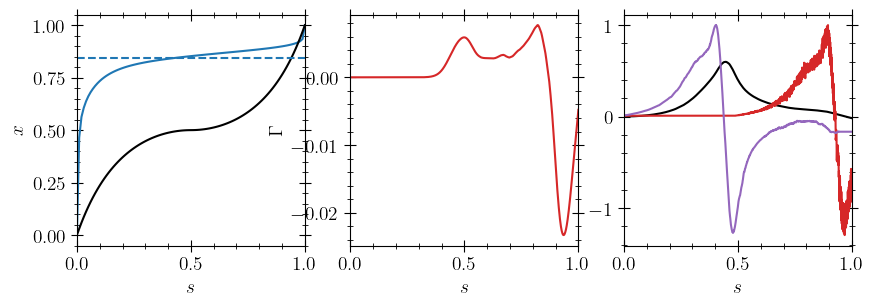

In [117]:
figure(figsize=(10, 3))

subplot(131)
plot(range(0, 1, 101), map(adaptive_schedule, T_anneal .* range(0, 1, 101)), "-")
plot(range(0, 1, 101), map(x -> tfim_sched(x), range(0, 1, 101)), "-k")
axhline(gaploc, ls="--")
xlim(0, 1)
# ylim(0, 1)
xlabel("\$s\$")
ylabel("\$x\$")

subplot(132)
# plot(x, map(Γ_AD, x), "-")
plot(x, map(Γ, x), "-C3")
xlabel("\$s\$")
ylabel("\$\\Gamma\$")
xlim(0, 1) 

subplot(133)


∂g_data = map(∂_sum_flucs_f, coarse_times) # map(x -> ForwardDiff.derivative(∂g_smooth, x), x)
navg = 32 # 1024
∂g_smooth_shifted = linear_interpolation(coarse_times[1:end - navg + 1], AdaptiveQuantumAnnealing.moving_average(map(∂_sum_flucs_f, coarse_times), navg), extrapolation_bc=Line())
∂g_smooth = x -> ∂g_smooth_shifted(x - navg / 2ninterp)
plot(x, map(sum_flucs_f, x), "-k", label="Sum")
plot(coarse_times, ∂g_data ./ maximum(∂g_data), "-C3")
plot(coarse_times, map(∂g_smooth, coarse_times) ./ maximum(map(∂g_smooth, coarse_times)), "-C4")
xlabel("\$s\$")
# ylabel("∂g")
xlim(0, 1) 
# ylim(-0.5, 0.5) 

display(gcf())
tight_layout()
# savefig(@sprintf("../plots/Schedule_and_Christoffel_L_%i.pdf", L))

In [118]:
# Just for thesis
# times_anneal = range(0, T_anneal, p+1);
# figure(figsize=(4, 3))

# # subplot(111)
# plot(times_anneal, map(adaptive_schedule, times_anneal), "-")
# axvline(T_anneal * gaploc, ls="--")
# xlim(0, T_anneal)
# ylim(0, 1)
# xlabel("\$t\$")
# ylabel("\$s(t)\$")


# display(gcf())
# tight_layout()

# savefig("/home/ubuntu/.julia/dev/AdaptiveQuantumAnnealing/temo_figures/new_schedule.pdf", bbox_inches="tight")

## Simulation

In [119]:
data_dict_adap = Dict()
data_dict_TFIM = Dict()
data_dict_fix = Dict();

In [120]:
# p = 10000
p = trunc(Int64, 20 * T_anneal)
τ = T_anneal/p
times_anneal = range(0, T_anneal, p+1);

In [121]:
# annealing_problem = QAOA.Problem(p, h, J_mat);
annealing_problem = QAOA.Problem(p, J_mat);

### Linear schedule

In [122]:
# linear_schedule(n, p) = n / p;
# beta_and_gamma = τ .* vcat([1 - linear_schedule(n, p) for n in 0:p-1], [linear_schedule(n, p) for n in 0:p-1]);

# circ = QAOA.circuit(annealing_problem)
# circ = QAOA.dispatch_parameters!(circ, annealing_problem, beta_and_gamma)
# probabilities = uniform_state(nqubits(circ)) |> circ |> probs;

In [123]:
# τ = T_anneal / p
γ = τ .* ((1:p) .- 1/2) ./ p |> collect
β = τ .* (1 .- (1:p) ./ p) |> collect
β[p] = τ / (4 * p);

In [124]:
probabilities = QAOA.anneal(annealing_problem, β, γ)
probabilities_linear = copy(probabilities)
data_dict_fix[T_anneal] = energies_and_probs(probabilities, annealing_problem)

([0.0000e+00, 1.3577e-01, 1.3680e-01, 3.9598e-01, 4.1583e-01, 5.2568e-01, 5.5022e-01, 5.7217e-01, 6.5436e-01, 6.6385e-01  …  1.3408e+01, 1.3441e+01, 1.3535e+01, 1.3542e+01, 1.3721e+01, 1.3735e+01, 1.3738e+01, 1.3826e+01, 1.3964e+01, 1.4007e+01], [4.0066e-04, 5.1251e-01, 4.8708e-01, 3.0157e-09, 3.7301e-09, 2.2377e-09, 1.0835e-09, 3.0391e-06, 1.6490e-06, 8.3143e-11  …  2.9540e-31, 2.0507e-30, 8.8003e-31, 9.2321e-31, 8.7022e-32, 4.5177e-30, 2.4602e-30, 1.3258e-30, 2.5252e-30, 4.4288e-31])

In [125]:
energy_from_max_prob(probabilities, annealing_problem)

(5.1251e-01, Dict{Any, Any}("111100011011" => -7.1272e+00))

### TFIM schedule

In [126]:
# β = τ .* [1.0 - tfim_sched(t / T_anneal) for t in times_anneal]
# γ = τ .* [tfim_sched(t / T_anneal) for t in times_anneal];

In [127]:
# probabilities = QAOA.anneal(annealing_problem, β, γ)
# data_dict_TFIM[T_anneal] = energies_and_probs(probabilities, annealing_problem)

### Adaptive schedule

In [128]:
# beta_and_gamma = τ .* vcat([1.0 - adaptive_schedule(t) for t in times_anneal[2:end]], [adaptive_schedule(t) for t in times_anneal[2:end]]);

# circ = QAOA.circuit(annealing_problem)
# circ = QAOA.dispatch_parameters(circ, annealing_problem, beta_and_gamma)
# probabilities = uniform_state(nqubits(circ)) |> circ |> probs;
# probabilities_adaptive = copy(probabilities);

In [129]:
# Second order simulation
γ = τ .* adaptive_schedule.(times_anneal)
β = τ .* [(1 - adaptive_schedule(times_anneal[i+1]) + 1 - adaptive_schedule(times_anneal[i]))/2 for i in 1:p-1] 
append!(β, τ * (1-adaptive_schedule(T_anneal))/2)
probabilities = QAOA.anneal(annealing_problem, β, γ)
probabilities_adaptive = copy(probabilities);

In [130]:
data_dict_adap[T_anneal] = energies_and_probs(probabilities, annealing_problem)

([0.0000e+00, 1.3577e-01, 1.3680e-01, 3.9598e-01, 4.1583e-01, 5.2568e-01, 5.5022e-01, 5.7217e-01, 6.5436e-01, 6.6385e-01  …  1.3408e+01, 1.3441e+01, 1.3535e+01, 1.3542e+01, 1.3721e+01, 1.3735e+01, 1.3738e+01, 1.3826e+01, 1.3964e+01, 1.4007e+01], [2.0939e-03, 4.9407e-01, 4.9982e-01, 3.2177e-05, 1.6971e-05, 3.9566e-06, 1.6785e-06, 2.3523e-03, 1.2984e-03, 5.8211e-07  …  6.0965e-22, 1.7181e-24, 1.4184e-21, 2.6886e-22, 5.4502e-23, 2.7755e-22, 2.5539e-22, 9.0452e-24, 1.6208e-23, 1.0137e-23])

In [131]:
energy_from_max_prob(probabilities, annealing_problem)

(4.9982e-01, Dict{Any, Any}("111101011011" => -7.1262e+00))

In [132]:
data_dict_adap[T_anneal][2][1] / data_dict_fix[T_anneal][2][1] |> println

5.2261e+00


## Plots

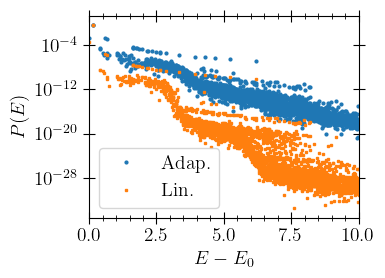

In [133]:
figure(figsize=(4, 3))
# plot([], [], label="\$T\$", lw=0)

for (T_f, (E, probs)) in sort(collect(data_dict_adap))
    semilogy(E, probs, "o", ms=2, label="Adap.")#label=string(T_f))
end

for (T_f, (E, probs)) in sort(collect(data_dict_fix))
    semilogy(E, probs, "s", ms=2, label="Lin.")#label=string(T_f))
end

# for (T_f, (E, probs)) in sort(collect(data_dict_gauss))
#     semilogy(E, probs, "s", ms=6, label="Gauss")#label=string(T_f))
# end

legend(frameon=true, ncol=1)
xlim(0, 10)
# ylim(1e-6, 1)
xlabel("\$E - E_0\$")
ylabel("\$P(E)\$")
tight_layout()
# savefig(@sprintf("../plots/Scatter_Weighted_MaxCut_L_%i.pdf", L))
display(gcf())

In [134]:
# energies_gauss, probabilities_gauss = data_dict_gauss[T_anneal]
energies_adap, probabilities_adap = data_dict_adap[T_anneal]
energies_lin, probabilities_lin = data_dict_fix[T_anneal];

In [135]:
# figure(figsize=(4, 3))
# hist(energies_adap[1:end-1], energies_adap, weights=probabilities_adap[1:end-1], alpha=0.75, label="Adap.")
# hist(energies_lin[1:end-1], energies_lin, weights=probabilities_lin[1:end-1], alpha=0.5, color="C3", label="Lin.")
# # hist(energies_gauss[1:end-1], energies_gauss, weights=probabilities_gauss[1:end-1], alpha=0.75, label="Gauss.")
# legend(frameon=false)
# xlim(0, 2)
# ylim(0, 0.1)
# xlabel("\$E - E_0\$")
# ylabel("\$P(E)\$")
# tight_layout()
# # savefig(@sprintf("../plots/Histogram_MAX2SAT_L_%i.pdf", L))
# display(gcf())

## Testing

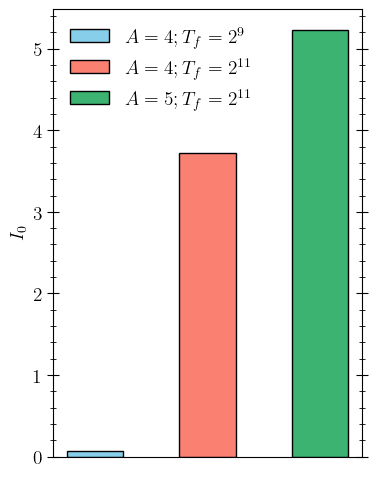

In [139]:
# Create figure and axis objects
figure(figsize=(4, 5))  # Slightly larger figure size for better clarity
ax = subplot(111)

# Define the positions and width for the bars
positions = [1,2,3]
bar_width = 0.5


# Plot bars for adaptive and linear data
bar(positions[1] - bar_width/2, 6.8497e-02, width=bar_width, label=L"A=4;T_{f} = 2^{9}", color="skyblue", edgecolor="black")
bar(positions[2] - bar_width/2, 3.7251e+00, width=bar_width, label=L"A=4;T_{f} = 2^{11}", color="salmon", edgecolor="black")
bar(positions[3] - bar_width/2, 5.2261e+00, width=bar_width, label=L"A=5;T_{f} = 2^{11}", color="mediumseagreen", edgecolor="black")

# Set limits and labels
xticks([])
# xlim(-2,2)
# ax.set_xticklabels([L"I_0"])
plt.ylabel(L"I_{0}")

# yticks([0.])
# ylim(-2,2)
# ax.set_yticklabels([L"P_0"])
plt.legend()


# Display the plot
plt.tight_layout()  # Adjust subplots to give some padding
display(gcf())
# savefig("/home/ubuntu/Archives/projects/Master_thesis/graphics/results/sk_ensemble/fine_tuning_improves.pdf", bbox_inches="tight")

In [137]:
df = AdaptiveQuantumAnnealing.energies_and_bitstrings_qaoa(mf_problem);
df[!,"adaptive_probs"] = probabilities_adaptive;
df[!,"linear_probs"] = probabilities_linear
df[!,"P_ratio"] = probabilities_adaptive ./ probabilities_linear
sort(df, [:energy], rev = false)

Row,bit_string,energy,adaptive_probs,linear_probs,P_ratio
,Any,Float64,Float64,Float64,Float64
1,"[1, 1, 1, 1, -1, -1, 1, 1, 1, -1, 1, -1]",-7.2630e+00,2.0939e-03,4.0066e-04,5.2261e+00
2,"[-1, -1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1]",-7.1272e+00,4.9407e-01,5.1251e-01,9.6400e-01
3,"[-1, -1, -1, -1, 1, -1, 1, -1, -1, 1, -1, -1]",-7.1262e+00,4.9982e-01,4.8708e-01,1.0262e+00
4,"[-1, -1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1]",-6.8670e+00,3.2177e-05,3.0157e-09,1.0670e+04
5,"[1, 1, 1, 1, -1, -1, 1, 1, 1, -1, -1, -1]",-6.8472e+00,1.6971e-05,3.7301e-09,4.5499e+03
6,"[-1, -1, -1, -1, -1, 1, 1, -1, 1, -1, -1, -1]",-6.7373e+00,3.9566e-06,2.2377e-09,1.7682e+03
7,"[1, -1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1]",-6.7128e+00,1.6785e-06,1.0835e-09,1.5491e+03
8,"[-1, -1, -1, -1, -1, -1, 1, -1, -1, 1, -1, -1]",-6.6908e+00,2.3523e-03,3.0391e-06,7.7401e+02
9,"[-1, -1, -1, -1, 1, 1, -1, -1, -1, 1, -1, -1]",-6.6086e+00,1.2984e-03,1.6490e-06,7.8738e+02


In [389]:
# Improvement from changing some parameters, wrote this, just to send to Tim
# file_name: old_probs; new_probs
# qaoa_36751 : 0.359; 1.7850
# qaoa_101613: 1.2476; 1.657
# qaoa_39490: 3.49; 3.2
# qaoa_109358: 0.39; 1.1754
# qaoa_129133: 0.257; 2.9237
# qaoa_121349: 0.2143; 0.1746(I think final time issues)
# qaoa_118489: 0.406602; 3.9909
# qaoa_18149: 5.02143; 10.2609
# qaoa_33950: 0.255486;3.3866
# qaoa_66265: 0.161811; 33.5437


UndefVarError: UndefVarError: file_name not defined

# Huge table performance for different N_

In [179]:
# This here is a pretty beefed up function that has all the essential code form above.
# It takes the file as input and gives out the final simulation result.

function performance_fill(seed, N)	
    PATH = PATH = "/home/ubuntu/Archives/"
    subdir = "small_gaps"
    # subdir = "large_gaps"
    folder_name = PATH * @sprintf("data/tb_mount_local/N_%i/%s/", N, subdir);
    	
    filename = folder_name * @sprintf("random_SK_instance_N_%i_seed_%i.h5", N, seed)
    J_mat = h5read(filename, "J");
    mf_problem = Problem(0, J_mat);



    T_final = 32768.
    npts = 2048
    coarse_times = range(0, 1, npts + 1);
    

    tol = 1e-6
    sol_t = h5read(folder_name * @sprintf("results_random_SK_instance_N_%i_seed_%i.h5", N, seed), @sprintf("mean_field_T_final_%.0f_tol_1e%.0f/times", T_final, log10(tol)))
    sol_u = h5read(folder_name * @sprintf("results_random_SK_instance_N_%i_seed_%i.h5", N, seed), @sprintf("mean_field_T_final_%.0f_tol_1e%.0f/trajectories", T_final, log10(tol)));
    
    nx_vals = n_vals("x", sol_u)
    ny_vals = n_vals("y", sol_u)
    nz_vals = n_vals("z", sol_u);
    nx_coarse = n_coarse(nx_vals, sol_t, coarse_times)
    ny_coarse = n_coarse(ny_vals, sol_t, coarse_times)
    nz_coarse = n_coarse(nz_vals, sol_t, coarse_times);
    S_vals = [transpose(reduce(hcat, [nx_coarse[:, k], ny_coarse[:, k], nz_coarse[:, k]])) |> Matrix for k in 1:npts+1]
    magnetizations = reduce(hcat, map(S -> magnetization(S, mf_problem.local_fields, mf_problem.couplings), S_vals));
    areas = Dict()
    EA_param = Dict()
    # dts = [(x[2] - x[1]) / T_final for x in zip(sol_t[1:end-1], sol_t[2:end])]
    dts = [(x[2] - x[1]) / T_final for x in zip(coarse_times[1:end-1], coarse_times[2:end])]
    for spin_idx in 1:N-1
        # areas[spin_idx] = sum(dts .* nz_vals[spin_idx, 2:end]) |> abs
        areas[spin_idx] = sum(dts .* magnetizations[spin_idx, 2:end]) |> abs

        # Edwards-Anderson
        EA_param[spin_idx] = (1/(N-1)) * sum(dts .* nz_coarse[spin_idx, 2:end] .^ 2) |> abs
    end

    top_idxs = [k for (k, v) in sort(areas |> collect, by = x -> x[2])]
    top_idxs = [k for (k, v) in sort(EA_param |> collect, by = x -> x[2])]
    top_idx = top_idxs[1]

    T_final = 32000.
    tol = 1e-8
    all_flucs = h5read(folder_name * @sprintf("results_random_SK_instance_N_%i_seed_%i.h5", N, seed), @sprintf("fluctuations_T_final_%.0f_tol_1e%.0f_npts_%i", T_final, log10(1e-8), npts));
    navg = 128
    sum_flucs_f_shifted = linear_interpolation(coarse_times[1:end - navg + 1], AdaptiveQuantumAnnealing.moving_average(sum([all_flucs[i, :] for i in 1:N-1]), navg), extrapolation_bc=Line())
    sum_flucs_f = x -> sum_flucs_f_shifted(x - (navg - 1) / 2npts)
    ∂_sum_flucs_f = x -> ForwardDiff.derivative(sum_flucs_f, x);
    local_EA_param = nz_coarse[top_idx, :].^2
    scale_factor = 1 .+ abs.(complex_coordinate(top_idx, nx_coarse, ny_coarse, nz_coarse)) .^ 2;

    g_ninterp = 20000
    g_navg = 500
    C = 4
    δₓ = 0.0
    metric_parameters = MetricParameters(g_ninterp, g_navg, C, δₓ);
    g = metric(metric_parameters, smoothen(scale_factor[2:end].^2 .* all_flucs[top_idx, 2:end] .* local_EA_param[2:end], coarse_times[2:end], navg=256), coarse_times)
    g_norm(x) = C .* g(x)./(1 * maximum(g.(range(0,1,1000))) )

    
    T_anneal = 1000.;
    # T_anneal = 2^13;
    adaptive_schedule_parameters = AdaptiveScheduleParameters(T_anneal, RK4(), [0.0, 1.0], 60000, 3000, 1e-6, 1e-7)
    adaptive_schedule = solve_boundary_value_problem(g_norm, adaptive_schedule_parameters)
    adaptive_schedule(T_anneal) 

    data_dict_adap = Dict()
    data_dict_TFIM = Dict()
    data_dict_fix = Dict();
    # p = 5000
    p = trunc(Int64, 10 * T_anneal)
    
    τ = T_anneal/p
    times_anneal = range(0, T_anneal, p+1);
    annealing_problem = QAOA.Problem(p,J_mat);

    lin_schedule(t) = t / T_anneal 
    γ = τ .* lin_schedule.(times_anneal)
    β = τ .* [(1 - lin_schedule(times_anneal[i+1]) + 1 - lin_schedule(times_anneal[i]))/2 for i in 1:p-1] 
    append!(β, τ * (1-lin_schedule(T_anneal))/2 )
        
    probabilities = QAOA.anneal(annealing_problem, β, γ)
    probabilities_linear = copy(probabilities)
    data_dict_fix[T_anneal] = energies_and_probs(probabilities, annealing_problem)

    γ = τ .* adaptive_schedule.(times_anneal)
    β = τ .* [(1 - adaptive_schedule(times_anneal[i+1]) + 1 - adaptive_schedule(times_anneal[i]))/2 for i in 1:p-1] 
    append!(β, τ * (1-adaptive_schedule(T_anneal))/2)
    probabilities = QAOA.anneal(annealing_problem, β, γ)
    probabilities_adaptive = copy(probabilities);
    
    df = AdaptiveQuantumAnnealing.energies_and_bitstrings_qaoa(mf_problem);
    df[!,"adaptive_probs"] = probabilities_adaptive;
    df[!,"linear_probs"] = probabilities_linear
    df[!,"P_ratio"] = probabilities_adaptive ./ probabilities_linear
    sort!(df, [:energy], rev = false)

    Arrow.write(@sprintf("/home/ubuntu/.julia/dev/AdaptiveQuantumAnnealing/notebooks/sk_filter_data/N_%i_perf/%i_.arrow", N, seed), df)

    println(seed,df[1, "P_ratio"],"|||", df[2, "P_ratio"],"|||",df[1,"linear_probs"],"|||", df[2,"linear_probs"])
    return (df[1, "P_ratio"], df[2, "P_ratio"],df[1,"linear_probs"], df[2,"linear_probs"])
end  

performance_fill (generic function with 1 method)

In [180]:
performance_fill(2112, 17)

21129.5185e-01|||2.0984e-01|||9.9504e-01|||4.4453e-03


(9.5185e-01, 2.0984e-01, 9.9504e-01, 4.4453e-03)

In [119]:
system_size = 17

17

In [120]:
df_extreme_peaks = DataFrame(Arrow.Table(@sprintf("/home/ubuntu/.julia/dev/AdaptiveQuantumAnnealing/notebooks/sk_filter_data/valid_seeds_%i.arrow", system_size)))

Row,seed,A
,Int64,SubArray…
1,2112,"[1.5305e+06, 5.1107e+01]"
2,25437,"[3.8719e+05, 1.0883e+01]"
3,2007,"[3.0821e+05, 4.0496e+00]"
4,27018,"[3.0054e+05, 4.1447e+01]"
5,22518,"[2.0606e+05, 1.2214e+01]"
6,1169,"[1.9305e+05, 1.0619e+01]"
7,5039,"[1.5796e+05, 7.9206e+00]"
8,11064,"[1.5302e+05, 1.7387e+01]"
9,25717,"[1.4412e+05, 1.0389e+01]"


In [121]:
df_extreme_peaks = sort(df_extreme_peaks, [:A], rev = true)[1:15,:]

Row,seed,A
,Int64,SubArray…
1,2112,"[1.5305e+06, 5.1107e+01]"
2,25437,"[3.8719e+05, 1.0883e+01]"
3,2007,"[3.0821e+05, 4.0496e+00]"
4,27018,"[3.0054e+05, 4.1447e+01]"
5,22518,"[2.0606e+05, 1.2214e+01]"
6,1169,"[1.9305e+05, 1.0619e+01]"
7,5039,"[1.5796e+05, 7.9206e+00]"
8,11064,"[1.5302e+05, 1.7387e+01]"
9,25717,"[1.4412e+05, 1.0389e+01]"


In [122]:
# This is where the huge function is called to add a column containing the simulaiton result
# transform!(df_extreme_peaks, [:seed] => ByRow(seed -> performance_fill(seed, system_size)) => [:gs_improve, :st_supress, :gs_lin, :st_lin])

# I thought dataframes.jl should automatically do multi threading, but its bs. 

InterruptException: InterruptException:

In [99]:
# Arrow.write(@sprintf("/home/ubuntu/.julia/dev/AdaptiveQuantumAnnealing/notebooks/sk_filter_data/N_%i_perf/extreme_peaks_2^14TF.arrow", system_size), df_extreme_peaks)

"/home/ubuntu/.julia/dev/AdaptiveQuantumAnnealing/notebooks/sk_filter_data/N_17_perf/extreme_peaks_2^14TF.arrow"

In [100]:
describe(df_extreme_peaks)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Any,Any,Union…,Any,Int64,DataType
1,seed,1.7070e+04,1169,2.1219e+04,27407,0,Int64
2,A,"[2.5231e+05, 1.7346e+01]","[4.2947e+04, 2.4600e+01]",,"[1.5305e+06, 5.1107e+01]",0,"SubArray{Float64, 1, Primitive{Float64, Vector{Float64}}, Tuple{UnitRange{Int64}}, true}"
3,gs_improve,4.3442e+00,1.8177e-01,2.0021e+00,1.9908e+01,0,Float64
4,st_supress,1.2061e+01,1.8134e-01,2.1918e+00,1.0307e+02,0,Float64
5,gs_lin,1.3658e-05,4.0471e-07,7.2935e-06,3.9809e-05,0,Float64
6,st_lin,1.8411e-05,1.4704e-07,9.4393e-06,5.3020e-05,0,Float64


In [101]:
# sort(df_extreme_peaks, [:gs_improve])

In [15]:
# Just reading the data that was generated
a_dummy = sort(DataFrame(Arrow.Table("/home/ubuntu/.julia/dev/AdaptiveQuantumAnnealing/notebooks/sk_filter_data/N_17_perf/extreme_peaks.arrow")), [:A], rev = true)[2:end-1, :]

Row,seed,A,gs_improve,st_supress,gs_lin,st_lin
,Int64,SubArray…,Float64,Float64,Float64,Float64
1,25437,"[3.87194e5, 10.8832]",16.5916,0.963591,0.000863984,0.998922
2,2007,"[3.08214e5, 4.0496]",852.196,0.961564,1.78008e-5,0.999379
3,27018,"[3.00541e5, 41.4474]",2.13452,0.963739,0.0286166,0.969972
4,22518,"[2.06058e5, 12.2136]",0.605229,0.993431,0.00325423,0.996535
5,1169,"[1.93049e5, 10.619]",51.0752,3.76204,0.000279191,1.20944e-5
6,5039,"[1.57959e5, 7.92065]",82836.8,0.836069,8.04166e-7,0.995662
7,11064,"[1.53018e5, 17.387]",57.7242,0.66211,0.00267776,0.965403
8,25717,"[1.44118e5, 10.3895]",584.276,3.3307,2.40247e-5,0.0017518
9,27407,"[84751.8, 9.91831]",2.55028,0.789212,0.0713127,0.92609


In [16]:
describe(a_dummy)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Any,Any,Union…,Any,Int64,DataType
1,seed,17509.8,1169,21219.0,27407,0,Int64
2,A,"[1.70092e5, 14.1915]","[51194.8, 3.21834]",,"[3.87194e5, 10.8832]",0,"SubArray{Float64, 1, Primitive{Float64, Vector{Float64}}, Tuple{UnitRange{Int64}}, true}"
3,gs_improve,6496.66,0.147923,16.5916,82836.8,0,Float64
4,st_supress,1.26191,0.628608,0.876812,3.76204,0,Float64
5,gs_lin,0.049125,8.04166e-7,0.00267776,0.497194,0,Float64
6,st_lin,0.762339,1.20944e-5,0.965403,0.999379,0,Float64
